In [1]:
import sys
sys.path.append("../DeepGeSeq/")
print(sys.path)

['/share/home/zhanglab/user/lijiaqi/NvTK_manuscript/5_NvTK_MPRA', '/share/home/zhanglab/user/lijiaqi/tools/cactus-bin-v2.6.12/lib', '/share/home/zhanglab/user/lijiaqi/NvTK_manuscript/5_NvTK_MPRA', '/share/home/zhanglab/user/lijiaqi/anaconda3/lib/python39.zip', '/share/home/zhanglab/user/lijiaqi/anaconda3/lib/python3.9', '/share/home/zhanglab/user/lijiaqi/anaconda3/lib/python3.9/lib-dynload', '', '/share/home/zhanglab/user/lijiaqi/anaconda3/lib/python3.9/site-packages', '/share/home/zhanglab/user/lijiaqi/anaconda3/lib/python3.9/site-packages/locket-0.2.1-py3.9.egg', '/share/home/zhanglab/user/lijiaqi/anaconda3/lib/python3.9/site-packages/IPython/extensions', '/share/home/zhanglab/user/lijiaqi/anaconda3/lib/python3.9/site-packages/setuptools/_vendor', '/share/home/zhanglab/user/lijiaqi/.ipython', '../DeepGeSeq/']


In [2]:
import h5py, os, argparse, logging, time

import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader

import DGS as dgs
from DGS.DL.Trainer import Trainer
from DGS.Model.ConvModel import CNN
from DGS.DL.Evaluator import calculate_regression_metrics

In [3]:
os.makedirs("./Log", exist_ok=True)
dgs.initialize_logger(time.strftime('./Log/log_nvtk_deepsea.%m%d.%H:%M:%S.txt'), verbosity=1)

# args
parser = argparse.ArgumentParser()
parser.add_argument("data")
parser.add_argument("--gpu-device", dest="device_id", default="0")
args = parser.parse_args(['data_MPRA/Dataset.CRE_Multi.h5', 
                          '--gpu-device', '3'])
logging.info(args)


In [4]:
## change device
os.environ["CUDA_VISIBLE_DEVICES"] = args.device_id
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Prepare dataset

1. unpack the h5file datasets
2. generate the DataLoader

In [5]:
# unpack datasets
h5file = h5py.File(args.data, 'r')
X = h5file["X"][:].swapaxes(1,-1).astype(np.float32)
Y = h5file["Y"][:].astype(np.float32)
varid = h5file["x_varid"][:].astype(str)
taskid = h5file["y_taskid"][:].astype(str)
h5file.close()

X.shape, Y.shape

((26437, 4, 87), (26437, 4))

In [6]:
Y = Y[:,:2]
taskid = taskid[:2]

In [7]:
# unpack anno
n_tasks = taskid.shape[0]
taskid

array(['CRE induced (100 uM forskolin, 5 hrs), replicate 1',
       'CRE induced (100 uM forskolin, 5 hrs), replicate 2'], dtype='<U50')

In [8]:
from sklearn.model_selection import train_test_split
train_idx, test_idx = train_test_split(range(X.shape[0]), test_size=0.2)
train_idx, val_idx = train_test_split(train_idx, test_size=0.2)
len(train_idx), len(test_idx), len(val_idx)

(16919, 5288, 4230)

In [9]:
x_train = X[train_idx]
x_val = X[test_idx]
x_test = X[val_idx]

x_train.shape, x_val.shape, x_test.shape

((16919, 4, 87), (5288, 4, 87), (4230, 4, 87))

In [10]:
y_train = Y[train_idx]
y_val = Y[test_idx]
y_test = Y[val_idx]

y_train.shape, y_val.shape, y_test.shape

((16919, 2), (5288, 2), (4230, 2))

In [11]:
# define data loader
batch_size = 1000
train_loader = DataLoader(list(zip(x_train, y_train)), batch_size=batch_size,
                            shuffle=True, num_workers=0, drop_last=False, pin_memory=True)
validate_loader = DataLoader(list(zip(x_val, y_val)), batch_size=batch_size, 
                            shuffle=False, num_workers=0, drop_last=False, pin_memory=True)
test_loader = DataLoader(list(zip(x_test, y_test)), batch_size=batch_size, 
                            shuffle=False, num_workers=0, drop_last=False, pin_memory=True)

## Define CNN model
Initialized CNN architectures in DGS

In [12]:
model = CNN(output_size=n_tasks)
model.Encoder.Conv.activation = nn.Sigmoid()
model.Decoder.activation = nn.Sigmoid()
model

CNN(
  (Embedding): BasicConvEmbed(
    (conv): Conv1d(4, 128, kernel_size=(3,), stride=(1,))
    (activation): ReLU()
    (pool): AvgPool1d(kernel_size=(3,), stride=(3,), padding=(0,))
  )
  (Encoder): Sequential(
    (Conv): BasicConv1d(
      (conv): Conv1d(128, 256, kernel_size=(3,), stride=(1,))
      (bn): BatchNorm1d(256, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
      (activation): Sigmoid()
      (dropout): Dropout(p=0.5, inplace=False)
      (pool): AvgPool1d(kernel_size=(3,), stride=(3,), padding=(0,))
    )
    (GAP): AdaptiveAvgPool1d(output_size=8)
    (Flatten): Flatten()
  )
  (Decoder): BasicLinearModule(
    (linear): Linear(in_features=2048, out_features=256, bias=True)
    (bn): BatchNorm1d(256, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    (activation): Sigmoid()
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (Predictor): BasicPredictor(
    (Map): Linear(in_features=256, out_features=2, bias=True)
    (Pred): Seque

In [13]:
optimizer = Adam([
    {'params': model.Embedding.parameters(), 'lr': 1e-6},
    {'params': model.Encoder.parameters(), 'lr': 1e-6},
    {'params': model.Decoder.parameters(), 'lr': 1e-5},
    {'params': model.Predictor.parameters(), 'lr': 1e-4}])
criterion = nn.MSELoss().to(device)
trainer = Trainer(model, criterion, optimizer, device, patience=5)

## Trained the model 
as an example, we only finetune the DeepSEA model architectures on TFBS sub-dataset for 10 EPOCHs.

In [14]:
# train
trainer.train(train_loader, validate_loader, epochs=40)

Epoch 7: 100%|██████████| 17/17 [00:00<00:00, 82.50it/s, loss=1.1989]


TrainerMetrics(train_losses=[1.4884346933925854, 1.3402178778367884, 1.2978308200836182, 1.2670640875311459, 1.2418346194659962, 1.2319448204601513, 1.2143488210790299, 1.1989310208488912], val_losses=[1.305206338564555, 1.2434120575586955, 1.238001525402069, 1.2419957915941875, 1.2449106176694233, 1.2504617770512898, 1.2615378697713215, 1.2770255208015442], train_metrics=[], val_metrics=[], best_val_loss=1.238001525402069, best_val_metric=0.0, best_epoch=2)

In [15]:
# if you have enabled tensorboard
# !tensorboard --logdir=runs --bind_all

## Evaluated the model

In [16]:
os.makedirs("./Test", exist_ok=True)

In [17]:
# predict test-set
_, _, test_predictions, test_targets = trainer.validate(test_loader, return_predictions=True)

# metric test-set
metric = calculate_regression_metrics(test_targets, test_predictions)
metric

,mse,rmse,mae,r2,pearson_r,pearson_p,spearman_r,spearman_p,kendall_tau,kendall_p
task_0,1.469114,1.212070,0.989923,-0.030725,0.609411,0.000000e+00,0.619508,0.0,0.438102,0.000000e+00
task_1,1.163061,1.078453,0.869016,-0.046415,0.539123,1.178025e-317,0.541619,0.0,0.378240,8.290373e-298


In [18]:
# from sklearn.metrics import r2_score
from scipy.stats import pearsonr
# r2_score(test_targets[:,0], test_predictions[:,0])
# r2_score(test_targets[:,1], test_predictions[:,1])
pearsonr(test_targets[:,0], test_targets[:,1])

PearsonRResult(statistic=0.8126836743791899, pvalue=0.0)

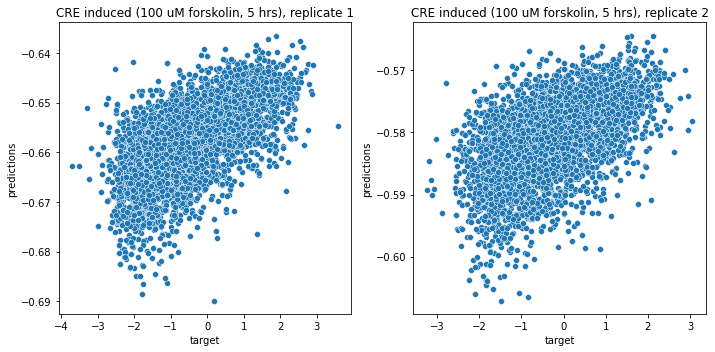

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
sns.scatterplot(x=test_targets[:,0], y=test_predictions[:,0])
plt.xlabel("target")
plt.ylabel("predictions")
plt.title(taskid[0])

plt.subplot(1,2,2)
sns.scatterplot(x=test_targets[:,1], y=test_predictions[:,1])
plt.xlabel("target")
plt.ylabel("predictions")
plt.title(taskid[1])

plt.tight_layout()
# plt.savefig("Test/Scatter.pdf", bbox_inches='tight')
plt.show()

## ISM
The sequence pattern deep learning represented internally for its accurate prediction.

Note: DeepSEA architecture have NO `model.Embedding.conv layer`, which is different to the NvTK predifined models.
We calculated the first-layer convolutional layer `model.conv_net[0]` as `hook_module` instead.
And the `motif_width` could be the filter_size of DeepSEA `model.conv_net[0]`.

In [20]:
import logomaker
os.makedirs("ISM", exist_ok=True)

In [21]:
import torch
import itertools
import numpy as np

# compute ism from sequence
def ism(model, x):
    
    model.eval()
    with torch.no_grad():
        
        x = x.to(device)
        y_ref = model.forward(x).cpu().data.numpy() #bs,os
        y_ref = y_ref[:, None, None, :] #bs,ls,ns,os

        bs, ns, ls = x.shape
        os = y_ref.shape[-1]
        y_alt = np.zeros((bs, ls, ns, os))
        
        for i in range(ls):
            for j in range(ns):
                tmp = x.clone()
                tmp[:,:,i] = torch.zeros_like(tmp[:,:,i])
                tmp[:,j,i] = torch.ones_like(tmp[:,j,i])
                y_tmp = model.forward(tmp).cpu().data.numpy() #bs,os
                y_alt[:,i,j,:] = y_tmp
        
        y_diff = y_alt - y_ref
        return y_diff 

def normalize_ism_score(x, y, y_diff):
    bs, ls, ns, os = y_diff.shape

    x = x.cpu().data.numpy().swapaxes(-1,1)
    y = y.cpu().data.numpy()[:,None,None,:]
    ref_nc = np.repeat(x[:,:,:,None], os, axis=-1)

    # use mean-Alts-3 as Ref-score
    y_diff_norm_ns = y_diff - np.repeat(y_diff.mean(axis=2)[:,:,None,:], ns, axis=2)
    ref_scores = ref_nc * y_diff_norm_ns

    ref_scores_norm_os = ref_scores - np.repeat(ref_scores.mean(axis=-1)[:,:,:,None], os, axis=-1)
    ref_scores_norm_os = (y * ref_scores_norm_os).mean(-1)

    return ref_scores_norm_os


In [22]:
ism_score, ism_score_normed = [], []

for d, t in test_loader:
    d = d.to(device)
    t = t.to(device)
    ism_s = ism(model, d)
    ism_s_n = normalize_ism_score(d, t, ism_s)
    ism_score.append(ism_s)
    ism_score_normed.append(ism_s_n)

ism_score = np.concatenate(ism_score, axis=0)
ism_score_normed = np.concatenate(ism_score_normed, axis=0)

ism_score.shape, ism_score_normed.shape

((4230, 87, 4, 2), (4230, 87, 4))

<Figure size 936x216 with 0 Axes>

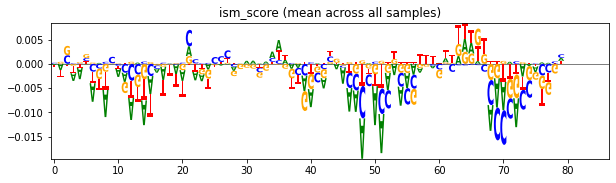

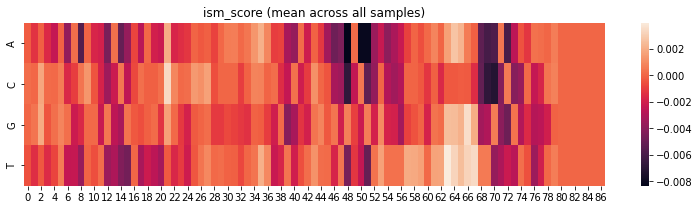

In [23]:
nn_df = pd.DataFrame(ism_score.mean(0)[:,:,0].T, index=['A','C','G','T']).T

plt.figure(figsize=(13, 3))
nn_logo = logomaker.Logo(nn_df)
plt.title("ism_score (mean across all samples)")
# plt.savefig("ISM/ism_score.pdf")
plt.show()

plt.figure(figsize=(13, 3))
sns.heatmap(nn_df.T)
plt.title("ism_score (mean across all samples)")
# plt.savefig("ISM/ism_score.heatmap.pdf")
plt.show()


Text(0.5, 1.0, 'ism_score (mean across all samples)')

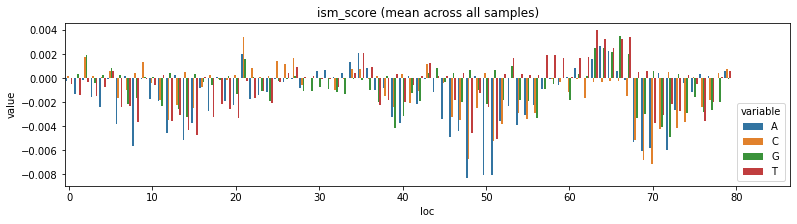

In [24]:
nn_df = pd.DataFrame(ism_score.mean(0)[:,:,0].T, index=['A','C','G','T']).T
nn_df['loc'] = nn_df.index
nn_df = nn_df.melt(id_vars="loc")

plt.figure(figsize=(13, 3))
sns.barplot(nn_df, x="loc", y="value", hue="variable")
plt.xticks(range(0, 87, 10))
plt.title("ism_score (mean across all samples)")
# plt.savefig("ISM/ism_score.barplot.pdf")

<Figure size 936x216 with 0 Axes>

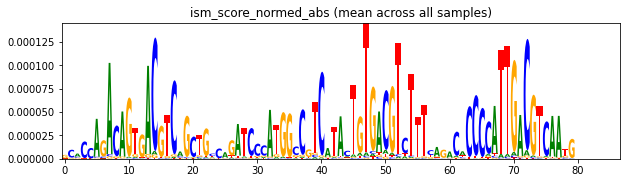

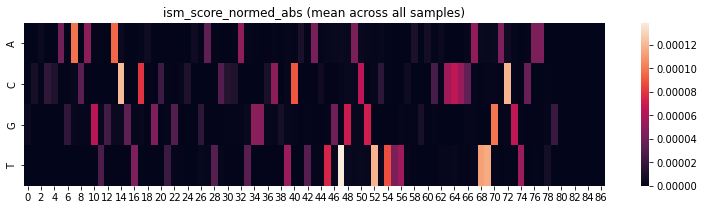

In [25]:
nn_df = pd.DataFrame(np.abs(ism_score_normed).mean(0).T, index=['A','C','G','T']).T

plt.figure(figsize=(13, 3))
nn_logo = logomaker.Logo(nn_df)
plt.title("ism_score_normed_abs (mean across all samples)")
# plt.savefig("ISM/ism_score_normed.pdf")
plt.show()

plt.figure(figsize=(13, 3))
sns.heatmap(nn_df.T)
plt.title("ism_score_normed_abs (mean across all samples)")
# plt.savefig("ISM/ism_score_normed.heatmap.pdf")
plt.show()


Text(0.5, 1.0, 'ism_score_normed_abs (mean across all samples)')

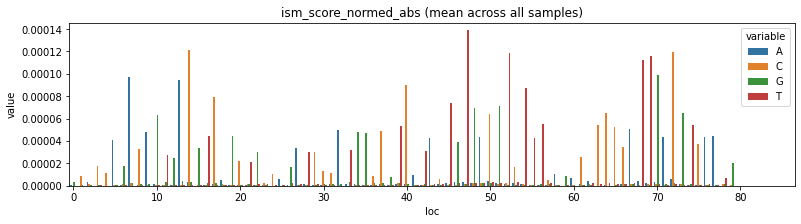

In [26]:
nn_df = pd.DataFrame(np.abs(ism_score_normed).mean(0).T, index=['A','C','G','T']).T
nn_df['loc'] = nn_df.index
nn_df = nn_df.melt(id_vars="loc")

plt.figure(figsize=(13, 3))
sns.barplot(nn_df, x="loc", y="value", hue="variable")
plt.xticks(range(0, 87, 10))
plt.title("ism_score_normed_abs (mean across all samples)")
# plt.savefig("ISM/ism_score_normed.barplot.pdf")